In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.io as io

import matplotlib.pyplot as plt
import seaborn as sns

from constants import SPATIAL, TEMPORAL, MORPHOLOGICAL
from constants import feature_names_org as feature_names
from perm_test import calc_perm_test

In [2]:
pd.options.display.max_columns = 500

In [3]:
mod_d = {'spatial': SPATIAL[:-1], 'temporal': TEMPORAL[:-1], 'morphological': MORPHOLOGICAL[:-1],
        'modalities': SPATIAL[:-1] + TEMPORAL[:-1] + MORPHOLOGICAL[:-1]}

spatial_families = {'value-based': ['spatial_dispersion_count', 'spatial_dispersion_sd', 'spatial_dispersion_area'],
                  'time_based': ['dep_red', 'dep_sd','fzc_red', 'fzc_sd', 'szc_red', 'szc_sd'],
                  'graph-based': ['dep_graph_avg_speed', 'dep_graph_slowest_path', 'dep_graph_fastest_path',
                           'fzc_graph_avg_speed', 'fzc_graph_slowest_path', 'fzc_graph_fastest_path',
                           'szc_graph_avg_speed', 'szc_graph_slowest_path', 'szc_graph_fastest_path']}

temporal_families = {'short': ['d_kl_start', 'unif_dist', 'rise_time'],
                     'long': ['d_kl_mid', 'jump'],
                     'wb': ['firing_rate', 'psd_center', 'der_psd_center']}

morph_families = {'WF': ['trough2peak', 'peak2peak', 'fwhm', 'rise_coef'],
                  'first': ['max_speed'],
                  'second': ['break_measure', 'smile_cry', 'get_acc']}

modality_families = {'spatial': [feature_names[i] for i in SPATIAL[:-1]],
                     'temporal': [feature_names[i] for i in TEMPORAL[:-1]],
                     'morphological': [feature_names[i] for i in MORPHOLOGICAL[:-1]]}

families_d = {'spatial': spatial_families, 'temporal': temporal_families, 'morphological': morph_families,
              'modalities': modality_families}

In [4]:
event_families = {'fzc': ['fzc_red', 'fzc_sd','fzc_graph_avg_speed', 'fzc_graph_slowest_path', 'fzc_graph_fastest_path'],
                  'dep': ['dep_red', 'dep_sd','dep_graph_avg_speed', 'dep_graph_slowest_path', 'dep_graph_fastest_path'],
                  'szc': ['szc_red', 'szc_sd','szc_graph_avg_speed', 'szc_graph_slowest_path', 'szc_graph_fastest_path']}

event_inds = [i for i in mod_d['spatial'] if 'spatial_dispersion' not in feature_names[i]]

mod_d['events'] = event_inds
families_d['events'] = event_families

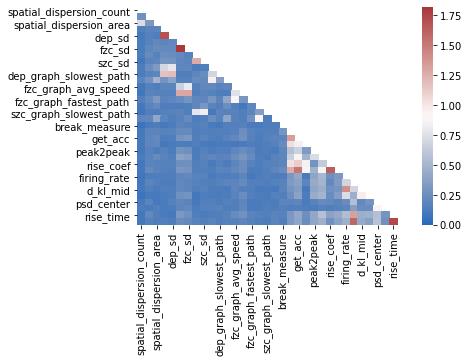

In [5]:
column_values = feature_names
mi_mat = io.loadmat('statistics/MIs.mat')['mis']
mi_mat = pd.DataFrame(data = mi_mat, 
                  index = column_values, 
                  columns = column_values)

mask = np.triu(np.ones_like(mi_mat, dtype=bool))
plt.yticks(rotation=30)
cmap = sns.color_palette("vlag", as_cmap=True)
vmax = mi_mat.to_numpy()[~mask].max()
_ = sns.heatmap(mi_mat, annot=False, fmt='.2f', mask=mask, vmin=0, vmax=vmax, cmap=cmap,
                    annot_kws={"fontsize": 1})

plt.show()

In [6]:
# this is for a specific MI we may state in the Results chapter
print('the MI between uniform distance and dkl_long is:', mi_mat['unif_dist'].d_kl_start)

the MI between uniform distance and dkl_long is: 1.6006944815671171


In [7]:
for mod in mod_d:
    print(mod)
    
    mod_mat = mi_mat.loc[[feature_names[i] for i in mod_d[mod]], [feature_names[i] for i in mod_d[mod]]]
    mod_np = mod_mat.to_numpy()
    mask = np.triu(np.ones_like(mod_np, dtype=bool))
    mod_np = mod_np[~mask]
    print(f'    median (IQR) MI: {np.median(mod_np): .3f} ({np.quantile(mod_np, 0.25): .3f}, {np.quantile(mod_np, 0.75): .3f})')
    print()
    
    for fam in families_d[mod]:
        fam_mat = mod_mat.loc[families_d[mod][fam], families_d[mod][fam]].to_numpy()
        mask = np.triu(np.ones_like(fam_mat, dtype=bool))
        fam_mat = fam_mat[~mask].flatten()
        if len(fam_mat) > 0:
            print(f'    median (IQR) MI of {fam}: {np.median(fam_mat): .3f} ({np.quantile(fam_mat, 0.25): .3f}, {np.quantile(fam_mat, 0.75): .3f})')
        else:
            print(f'    median (IQR) MI of {fam}: None (None None)')        
    print()
        
    for i, fam1 in enumerate(families_d[mod]):
        for j, fam2 in enumerate(families_d[mod]):
            if i >= j:
                continue
            cross_mat = mod_mat.loc[families_d[mod][fam1], families_d[mod][fam2]].to_numpy().flatten()
            print(f'    median (IQR) MI of {fam1} X {fam2}: {np.median(cross_mat): .3f} ({np.quantile(cross_mat, 0.25): .3f}, {np.quantile(cross_mat, 0.75): .3f})')    
    print()

spatial
    median (IQR) MI:  0.190 ( 0.155,  0.266)

    median (IQR) MI of value-based:  0.326 ( 0.296,  0.528)
    median (IQR) MI of time_based:  0.217 ( 0.208,  0.283)
    median (IQR) MI of graph-based:  0.186 ( 0.159,  0.313)

    median (IQR) MI of value-based X time_based:  0.168 ( 0.134,  0.195)
    median (IQR) MI of value-based X graph-based:  0.177 ( 0.137,  0.218)
    median (IQR) MI of time_based X graph-based:  0.192 ( 0.157,  0.270)

temporal
    median (IQR) MI:  0.469 ( 0.283,  0.701)

    median (IQR) MI of short:  1.601 ( 1.461,  1.668)
    median (IQR) MI of long:  0.976 ( 0.976,  0.976)
    median (IQR) MI of wb:  0.233 ( 0.212,  0.570)

    median (IQR) MI of short X long:  0.458 ( 0.437,  0.471)
    median (IQR) MI of short X wb:  0.552 ( 0.360,  0.566)
    median (IQR) MI of long X wb:  0.263 ( 0.244,  0.613)

morphological
    median (IQR) MI:  0.658 ( 0.292,  0.955)

    median (IQR) MI of WF:  0.640 ( 0.586,  0.708)
    median (IQR) MI of first: None (None 

In [8]:
wf_mat = mi_mat.loc[[feature_names[i] for i in mod_d['morphological']],[feature_names[i] for i in mod_d['morphological']]]
wf_np = wf_mat.to_numpy()
mask_wf = np.triu(np.ones_like(wf_np, dtype=bool))
wf_np = wf_np[~mask_wf]

temp_mat = mi_mat.loc[[feature_names[i] for i in mod_d['temporal']],[feature_names[i] for i in mod_d['temporal']]]
temp_np = temp_mat.to_numpy()
mask_temp = np.triu(np.ones_like(temp_np, dtype=bool))
temp_np = temp_np[~mask_temp]

spat_mat = mi_mat.loc[[feature_names[i] for i in mod_d['spatial']],[feature_names[i] for i in mod_d['spatial']]]
spat_np = spat_mat.to_numpy()
mask_spat = np.triu(np.ones_like(spat_np, dtype=bool))
spat_np = spat_np[~mask_spat]

print('MI differences between modalities')
print(f'TEMP-SPAT p-value={calc_perm_test(temp_np, spat_np, reps=1000)}\n')
print(f'WF-SPAT p-value={calc_perm_test(wf_np, spat_np, reps=1000)}\n')


MI differences between modalities
TEMP-SPAT p-value=0.000999000999000999

WF-SPAT p-value=0.000999000999000999



spatial
Median (IQR) MI of spatial_dispersion_count:  0.126 ( 0.104,  0.155)
Median (IQR) MI of spatial_dispersion_sd:  0.182 ( 0.172,  0.233)
Median (IQR) MI of spatial_dispersion_area:  0.207 ( 0.170,  0.326)
Median (IQR) MI of dep_red:  0.189 ( 0.180,  0.281)
Median (IQR) MI of dep_sd:  0.200 ( 0.157,  0.283)
Median (IQR) MI of fzc_red:  0.194 ( 0.170,  0.217)
Median (IQR) MI of fzc_sd:  0.201 ( 0.164,  0.231)
Median (IQR) MI of szc_red:  0.202 ( 0.161,  0.237)
Median (IQR) MI of szc_sd:  0.205 ( 0.181,  0.282)
Median (IQR) MI of dep_graph_avg_speed:  0.208 ( 0.161,  0.327)
Median (IQR) MI of dep_graph_slowest_path:  0.182 ( 0.154,  0.236)
Median (IQR) MI of dep_graph_fastest_path:  0.254 ( 0.188,  0.386)
Median (IQR) MI of fzc_graph_avg_speed:  0.188 ( 0.161,  0.212)
Median (IQR) MI of fzc_graph_slowest_path:  0.158 ( 0.142,  0.182)
Median (IQR) MI of fzc_graph_fastest_path:  0.218 ( 0.200,  0.293)
Median (IQR) MI of szc_graph_avg_speed:  0.172 ( 0.138,  0.219)
Median (IQR) MI of s

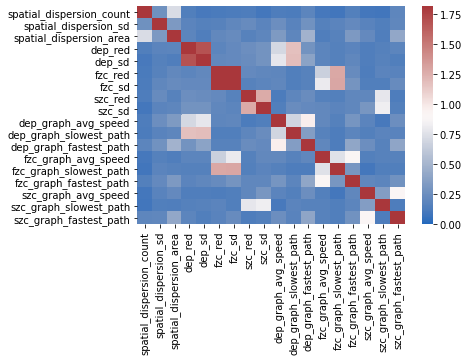

temporal
Median (IQR) MI of firing_rate:  0.552 ( 0.348,  0.707)
Median (IQR) MI of d_kl_start:  0.689 ( 0.512,  1.008)
Median (IQR) MI of d_kl_mid:  0.458 ( 0.337,  0.835)
Median (IQR) MI of jump:  0.458 ( 0.322,  0.600)
Median (IQR) MI of psd_center:  0.566 ( 0.256,  0.572)
Median (IQR) MI of der_psd_center:  0.267 ( 0.245,  0.322)
Median (IQR) MI of rise_time:  0.552 ( 0.467,  0.944)
Median (IQR) MI of unif_dist:  0.463 ( 0.398,  1.089)


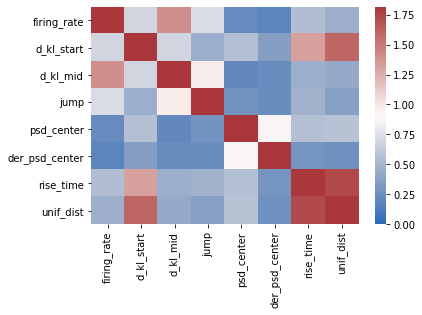

morphological
Median (IQR) MI of break_measure:  0.195 ( 0.194,  0.234)
Median (IQR) MI of fwhm:  1.030 ( 0.609,  1.154)
Median (IQR) MI of get_acc:  0.864 ( 0.752,  1.225)
Median (IQR) MI of max_speed:  0.832 ( 0.406,  0.891)
Median (IQR) MI of peak2peak:  0.481 ( 0.304,  0.621)
Median (IQR) MI of trough2peak:  0.646 ( 0.558,  0.795)
Median (IQR) MI of rise_coef:  0.851 ( 0.456,  1.073)
Median (IQR) MI of smile_cry:  0.930 ( 0.671,  1.393)


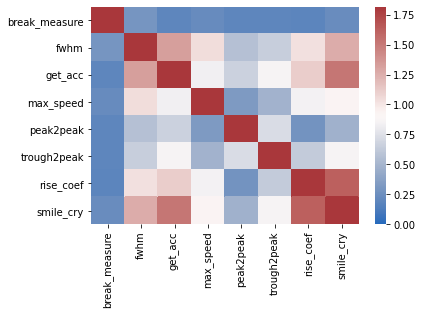

modalities
Median (IQR) MI of spatial_dispersion_count:  0.107 ( 0.096,  0.126)
Median (IQR) MI of spatial_dispersion_sd:  0.178 ( 0.160,  0.203)
Median (IQR) MI of spatial_dispersion_area:  0.179 ( 0.138,  0.219)
Median (IQR) MI of dep_red:  0.158 ( 0.137,  0.189)
Median (IQR) MI of dep_sd:  0.154 ( 0.135,  0.200)
Median (IQR) MI of fzc_red:  0.210 ( 0.187,  0.266)
Median (IQR) MI of fzc_sd:  0.210 ( 0.178,  0.267)
Median (IQR) MI of szc_red:  0.156 ( 0.139,  0.202)
Median (IQR) MI of szc_sd:  0.170 ( 0.152,  0.205)
Median (IQR) MI of dep_graph_avg_speed:  0.155 ( 0.131,  0.208)
Median (IQR) MI of dep_graph_slowest_path:  0.156 ( 0.138,  0.188)
Median (IQR) MI of dep_graph_fastest_path:  0.173 ( 0.152,  0.254)
Median (IQR) MI of fzc_graph_avg_speed:  0.186 ( 0.160,  0.209)
Median (IQR) MI of fzc_graph_slowest_path:  0.185 ( 0.154,  0.249)
Median (IQR) MI of fzc_graph_fastest_path:  0.185 ( 0.155,  0.229)
Median (IQR) MI of szc_graph_avg_speed:  0.140 ( 0.127,  0.172)
Median (IQR) MI o

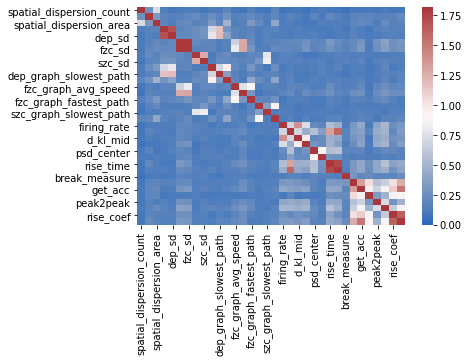

events
Median (IQR) MI of dep_red:  0.203 ( 0.182,  0.282)
Median (IQR) MI of dep_sd:  0.213 ( 0.171,  0.360)
Median (IQR) MI of fzc_red:  0.200 ( 0.176,  0.229)
Median (IQR) MI of fzc_sd:  0.207 ( 0.164,  0.274)
Median (IQR) MI of szc_red:  0.204 ( 0.162,  0.239)
Median (IQR) MI of szc_sd:  0.216 ( 0.193,  0.283)
Median (IQR) MI of dep_graph_avg_speed:  0.203 ( 0.165,  0.592)
Median (IQR) MI of dep_graph_slowest_path:  0.185 ( 0.157,  0.320)
Median (IQR) MI of dep_graph_fastest_path:  0.247 ( 0.174,  0.376)
Median (IQR) MI of fzc_graph_avg_speed:  0.195 ( 0.168,  0.552)
Median (IQR) MI of fzc_graph_slowest_path:  0.158 ( 0.144,  0.271)
Median (IQR) MI of fzc_graph_fastest_path:  0.219 ( 0.201,  0.292)
Median (IQR) MI of szc_graph_avg_speed:  0.166 ( 0.139,  0.241)
Median (IQR) MI of szc_graph_slowest_path:  0.164 ( 0.150,  0.184)
Median (IQR) MI of szc_graph_fastest_path:  0.174 ( 0.149,  0.246)


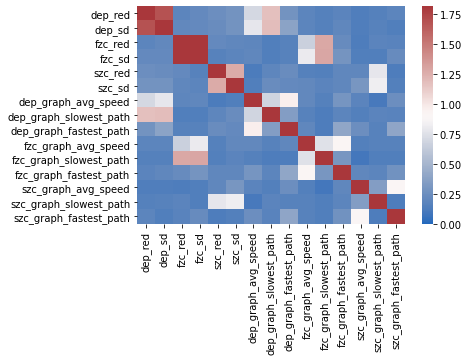

In [9]:
for mod in mod_d:
    print(mod)
    mod_mat = mi_mat.loc[[feature_names[i] for i in mod_d[mod]],[feature_names[i] for i in mod_d[mod]]]
    mod_np = mod_mat.to_numpy()
    
    for i, col in enumerate(mod_mat.columns):
        col_mi = mod_mat[[col]].to_numpy()
        col_mi = np.concatenate((col_mi[:i], col_mi[i + 1:]), axis=0)

        print(f'Median (IQR) MI of {col}: {np.median(col_mi): .3f} ({np.quantile(col_mi, 0.25): .3f}, {np.quantile(col_mi, 0.75): .3f})')
    
    _ = sns.heatmap(mod_mat, annot=False, fmt='.2f', cmap=cmap, vmin=0, vmax=vmax, annot_kws={"fontsize": 1})

    plt.show()

In [10]:
for mod in mod_d:
    print(mod)
    mod_mat = mi_mat.loc[[feature_names[i] for i in mod_d[mod]],[feature_names[i] for i in mod_d[mod]]]
    
    intra_fam = []
    for fam in families_d[mod]:
        fam_mat = mod_mat.loc[families_d[mod][fam], families_d[mod][fam]].to_numpy()
        mask = np.triu(np.ones_like(fam_mat, dtype=bool))
        fam_mat = fam_mat[~mask].flatten()
        intra_fam.append(fam_mat)
    intra_fam = np.concatenate(intra_fam)        
    
    inter_fam = []
    for i, fam1 in enumerate(families_d[mod]):
        for j, fam2 in enumerate(families_d[mod]):
            if i >= j:
                continue
            cross_mat = mod_mat.loc[families_d[mod][fam1], families_d[mod][fam2]].to_numpy().flatten()
            inter_fam.append(cross_mat)
    inter_fam = np.concatenate(inter_fam)
    
    print(f'Median (IQR) MI of intra-family: {np.median(intra_fam): .4f} ({np.quantile(intra_fam, 0.25): .4f}, {np.quantile(intra_fam, 0.75): .4f})')
    print(f'Median (IQR) MI of inter-family: {np.median(inter_fam): .4f} ({np.quantile(inter_fam, 0.25): .4f}, {np.quantile(inter_fam, 0.75): .4f})')
    print(f'p-value={calc_perm_test(intra_fam, inter_fam, reps=1000)}\n')


spatial
Median (IQR) MI of intra-family:  0.2134 ( 0.1678,  0.3198)
Median (IQR) MI of inter-family:  0.1813 ( 0.1477,  0.2300)
p-value=0.005994005994005994

temporal
Median (IQR) MI of intra-family:  0.9764 ( 0.5704,  1.4613)
Median (IQR) MI of inter-family:  0.4581 ( 0.2845,  0.5664)
p-value=0.01098901098901099

morphological
Median (IQR) MI of intra-family:  0.6336 ( 0.2790,  0.7289)
Median (IQR) MI of inter-family:  0.8323 ( 0.3130,  0.9872)
p-value=0.2017982017982018

modalities
Median (IQR) MI of intra-family:  0.2173 ( 0.1666,  0.4759)
Median (IQR) MI of inter-family:  0.1565 ( 0.1315,  0.1972)
p-value=0.000999000999000999

events
Median (IQR) MI of intra-family:  0.7318 ( 0.3013,  0.9553)
Median (IQR) MI of inter-family:  0.1813 ( 0.1557,  0.2098)
p-value=0.000999000999000999



In [11]:
non_short = ['d_kl_mid', 'jump', 'firing_rate', 'psd_center', 'der_psd_center']
non_short_mis = mi_mat.loc[non_short, non_short].to_numpy()
mask = np.triu(np.ones_like(non_short_mis, dtype=bool))
non_short_mis = non_short_mis[~mask].flatten()

short = ['d_kl_start', 'unif_dist', 'rise_time']
short_mis = mi_mat.loc[short, short].to_numpy()
mask = np.triu(np.ones_like(short_mis, dtype=bool))
short_mis = short_mis[~mask].flatten()

print(f'p-value={calc_perm_test(short_mis, non_short_mis, reps=1000)}\n')
print(f'Median (IQR) MI of non-high-freq: {np.median(non_short_mis): .3f} ({np.quantile(non_short_mis, 0.25): .3f}, {np.quantile(non_short_mis, 0.75): .3f})')

p-value=0.01898101898101898

Median (IQR) MI of non-high-freq:  0.263 ( 0.236,  0.862)
